# Machine Learning Engineer Nanodegree
## Reinforcement Learning
## Project: Train a Smartcab to Drive

Welcome to the fourth project of the Machine Learning Engineer Nanodegree! In this notebook, template code has already been provided for you to aid in your analysis of the *Smartcab* and your implemented learning algorithm. You will not need to modify the included code beyond what is requested. There will be questions that you must answer which relate to the project and the visualizations provided in the notebook. Each section where you will answer a question is preceded by a **'Question X'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide in `agent.py`.  

-----

## Getting Started
In this project, you will work towards constructing an optimized Q-Learning driving agent that will navigate a *Smartcab* through its environment towards a goal. Since the *Smartcab* is expected to drive passengers from one location to another, the driving agent will be evaluated on two very important metrics: **Safety** and **Reliability**. A driving agent that gets the *Smartcab* to its destination while running red lights or narrowly avoiding accidents would be considered **unsafe**. Similarly, a driving agent that frequently fails to reach the destination in time would be considered **unreliable**. Maximizing the driving agent's **safety** and **reliability** would ensure that *Smartcabs* have a permanent place in the transportation industry.

**Safety** and **Reliability** are measured using a letter-grade system as follows:

| Grade 	| Safety 	| Reliability 	|
|:-----:	|:------:	|:-----------:	|
|   A+  	|  Agent commits no traffic violations,<br/>and always chooses the correct action. | Agent reaches the destination in time<br />for 100% of trips. |
|   A   	|  Agent commits few minor traffic violations,<br/>such as failing to move on a green light. | Agent reaches the destination on time<br />for at least 90% of trips. |
|   B   	| Agent commits frequent minor traffic violations,<br/>such as failing to move on a green light. | Agent reaches the destination on time<br />for at least 80% of trips. |
|   C   	|  Agent commits at least one major traffic violation,<br/> such as driving through a red light. | Agent reaches the destination on time<br />for at least 70% of trips. |
|   D   	| Agent causes at least one minor accident,<br/> such as turning left on green with oncoming traffic.       	| Agent reaches the destination on time<br />for at least 60% of trips. |
|   F   	|  Agent causes at least one major accident,<br />such as driving through a red light with cross-traffic.      	| Agent fails to reach the destination on time<br />for at least 60% of trips. |

To assist evaluating these important metrics, you will need to load visualization code that will be used later on in the project. Run the code cell below to import this code which is required for your analysis.

In [1]:
# Import the visualization code
import visuals as vs
import math

# Pretty display for notebooks
%matplotlib inline

### Understand the World
Before starting to work on implementing your driving agent, it's necessary to first understand the world (environment) which the *Smartcab* and driving agent work in. One of the major components to building a self-learning agent is understanding the characteristics about the agent, which includes how the agent operates. To begin, simply run the `agent.py` agent code exactly how it is -- no need to make any additions whatsoever. Let the resulting simulation run for some time to see the various working components. Note that in the visual simulation (if enabled), the **white vehicle** is the *Smartcab*.

### Question 1
In a few sentences, describe what you observe during the simulation when running the default `agent.py` agent code. Some things you could consider:
- *Does the Smartcab move at all during the simulation?*
- *What kind of rewards is the driving agent receiving?*
- *How does the light changing color affect the rewards?*  

**Hint:** From the `/smartcab/` top-level directory (where this notebook is located), run the command 
```bash
'python smartcab/agent.py'
```

**Answer:** Running the default `agent.py` code runs the simulation with a stationary _Smartcab_ no matter the traffic or red/green lights. The driver agent, in this situation, is rewarded for properly idling at a red light, and punished (i.e. receives a negative reward) for idling at a green light when there is no oncoming traffic. There seems to be a slight increase in punishment for additional timesteps spent idling at the same green light, and similiarly a slight decrease in reward for idling at the same red light. Additionally, there is no deadline for the cab to reach the destination, so the simulation will run indefinitely since the _Smartcab_ will never move. 

### Understand the Code
In addition to understanding the world, it is also necessary to understand the code itself that governs how the world, simulation, and so on operate. Attempting to create a driving agent would be difficult without having at least explored the *"hidden"* devices that make everything work. In the `/smartcab/` top-level directory, there are two folders: `/logs/` (which will be used later) and `/smartcab/`. Open the `/smartcab/` folder and explore each Python file included, then answer the following question.

### Question 2
- *In the *`agent.py`* Python file, choose three flags that can be set and explain how they change the simulation.*
- *In the *`environment.py`* Python file, what Environment class function is called when an agent performs an action?*
- *In the *`simulator.py`* Python file, what is the difference between the *`'render_text()'`* function and the *`'render()'`* function?*
- *In the *`planner.py`* Python file, will the *`'next_waypoint()'`* function consider the North-South or East-West direction first?*

**Answer:** In `agent.py`,
- **`learning`** = flag in `env.create_agent()`; one of the most important flags for completing the assignment, setting to `True` forces the driving agent to start using Q-learning. This will actually allow the _Smartcab_ to start learning from the rewards and punishments to find a more optimal way of driving. 
- **`verbose`** = flag in `Environment()`; displays more output from the simulation, such as timestep, heading, action, and data from that timestep given the _Smartcab's_ current situation. This doesn't change the simulation, just how much information is displayed in the terminal or saved to a log.
- **`log_metrics`** = flag in `Simulator(env)`; logs output of trial and simulation results to `/logs/`. Again, this does not change the simulation, just stores the log of the terminal output for future use.

In `environment.py`,
- Considering the `DummyAgent`, it seems that after it choses a random valid movement (it doesn't want to idle ever) or idles if that movement would break the law, it passes the movement, `action`, to `self.env.act(self, action)`. The `self`s refer to the `DummyAgent` and the `env` refers to the passed environment variable. This leads me to conclude that the `Environment` class function called when an agent performs an action is `act`. 

In `simulator.py`, 
- `render_text()` prints simulation result data to the terminal, while `render()` creates the Pygame GUI that renders simulation data graphically. 

In `planner.py`,
- Once `dx` and `dy`&mdash;the true distance to the destination since our world's roads wrap at the borders&mdash;is calculated, the first `if` checks if we're at the destination (i.e. with `if dx==0 and dy==0`), then the first `elif` checks whether `dx != 0`. By the comment in the code we see this is checking the East-West direction, but we can also see this by noting `dx` represents delta-x aka change of x, and the x coordinate is usually the the horizontal direction. We could further go down the rabbit hole and confirm the `env.agent_states` ordered dictionary entry for `'location'` stores locations with the east-west coordinate first, but I think this is sufficient. 

-----
## Implement a Basic Driving Agent

The first step to creating an optimized Q-Learning driving agent is getting the agent to actually take valid actions. In this case, a valid action is one of `None`, (do nothing) `'left'` (turn left), `right'` (turn right), or `'forward'` (go forward). For your first implementation, navigate to the `'choose_action()'` agent function and make the driving agent randomly choose one of these actions. Note that you have access to several class variables that will help you write this functionality, such as `'self.learning'` and `'self.valid_actions'`. Once implemented, run the agent file and simulation briefly to confirm that your driving agent is taking a random action each time step.

### Basic Agent Simulation Results
To obtain results from the initial simulation, you will need to adjust following flags:
- `'enforce_deadline'` - Set this to `True` to force the driving agent to capture whether it reaches the destination in time.
- `'update_delay'` - Set this to a small value (such as `0.01`) to reduce the time between steps in each trial.
- `'log_metrics'` - Set this to `True` to log the simluation results as a `.csv` file in `/logs/`.
- `'n_test'` - Set this to `'10'` to perform 10 testing trials.

Optionally, you may disable to the visual simulation (which can make the trials go faster) by setting the `'display'` flag to `False`. Flags that have been set here should be returned to their default setting when debugging. It is important that you understand what each flag does and how it affects the simulation!

Once you have successfully completed the initial simulation (there should have been 20 training trials and 10 testing trials), run the code cell below to visualize the results. Note that log files are overwritten when identical simulations are run, so be careful with what log file is being loaded!
Run the agent.py file after setting the flags from projects/smartcab folder instead of projects/smartcab/smartcab.


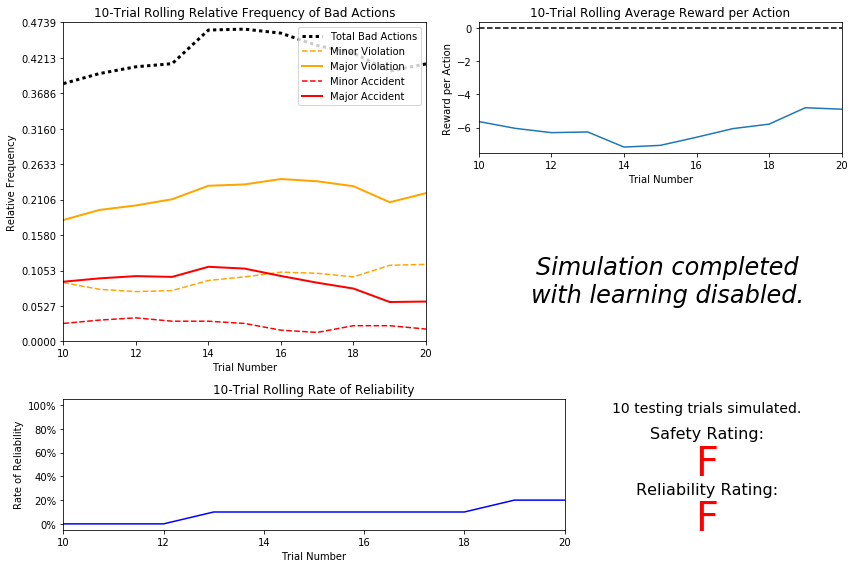

In [2]:
# Load the 'sim_no-learning' log file from the initial simulation results
vs.plot_trials('sim_no-learning.csv')

### Question 3
Using the visualization above that was produced from your initial simulation, provide an analysis and make several observations about the driving agent. Be sure that you are making at least one observation about each panel present in the visualization. Some things you could consider:
- *How frequently is the driving agent making bad decisions? How many of those bad decisions cause accidents?*
- *Given that the agent is driving randomly, does the rate of reliability make sense?*
- *What kind of rewards is the agent receiving for its actions? Do the rewards suggest it has been penalized heavily?*
- *As the number of trials increases, does the outcome of results change significantly?*
- *Would this Smartcab be considered safe and/or reliable for its passengers? Why or why not?*

**Answer:** The driving agent is making bad decisions somewhere about 40-45% of the time. Minor plus major accidents occur about 10% of total actions, so almost a quarter of bad decisions lead to an accident. Interestingly, major violations and accidents occur more frequently than minor ones; however, this is reasonable given the agent is acting randomly and how easy it is to get into trouble on the road. See the next code block for the percentage of bad actions.

In [3]:
import ast, pandas as pd
def bad_actions_percent(logfile, start=0, stop=None):
    with open(logfile) as f:
        data = pd.read_csv(f)
    action_dicts = data['actions'].iloc[start:stop].apply(ast.literal_eval)
    good_actions, total_actions = sum(d[0] for d in action_dicts), sum(sum(d.values()) for d in action_dicts)
    bad_avg = (1-float(good_actions)/total_actions)*100
    print 'Overall, the agent took bad actions {:.2f}% of the time.'.format(bad_avg)
bad_actions_percent('logs/sim_no-learning.csv')

Overall, the agent took bad actions 41.30% of the time.


This particular rate of reliability does not make sense to me, as there is no particular reason why a random driving agent should improve over time. However, I forgot to note that this is a "rolling rate of reliability", and that there were only 20 training trials to draw from. The relevant code follows:

    data['reliability_rate'] = (data['success'] * 100).rolling(window=10, center=False).mean()
    
The `data['success']` column records if the cab ride reached its destination. Thus, if there's one success and nine failures in the window from the current trial to the nine previous, the rolling rate of reliability for that trial will be 10%. So, that means we can conclude that a success occured at trial 13 and 19 and that the overall success rate was 2/20 rides aka 10%, but since the window at trial 20 includes both success, it looks like it became more reliable over time. It seems more reasonable when viewed the overall way as here it looks like it was getting better even though the successes came during the last 10 so nothing was dropped. I am surprised it found the destination even twice however, once would have been good enough for random. 

The agent is receiving chiefly negative rewards on average. Since the it's taking a lot of bad actions, committing major violations and getting into accidents, it makes sense that it's been penalized heavily overall, since its reward per action is negative. 

From these graphs it looks like it improves towards the last trials, but this is consistent with random actions; sometimes they find a target. I have already covered why the reliability looks like it's improving over time (any success is always in the rolling window). 

Clearly, this _Smartcab_ is not safe or reliable for passengers. If you need an explanation for why, go into your car and take random actions at intersections, and you can tell me if you get back why that's not a good idea.

-----
## Inform the Driving Agent
The second step to creating an optimized Q-learning driving agent is defining a set of states that the agent can occupy in the environment. Depending on the input, sensory data, and additional variables available to the driving agent, a set of states can be defined for the agent so that it can eventually *learn* what action it should take when occupying a state. The condition of `'if state then action'` for each state is called a **policy**, and is ultimately what the driving agent is expected to learn. Without defining states, the driving agent would never understand which action is most optimal -- or even what environmental variables and conditions it cares about!

### Identify States
Inspecting the `'build_state()'` agent function shows that the driving agent is given the following data from the environment:
- `'waypoint'`, which is the direction the *Smartcab* should drive leading to the destination, relative to the *Smartcab*'s heading.
- `'inputs'`, which is the sensor data from the *Smartcab*. It includes 
  - `'light'`, the color of the light.
  - `'left'`, the intended direction of travel for a vehicle to the *Smartcab*'s left. Returns `None` if no vehicle is present.
  - `'right'`, the intended direction of travel for a vehicle to the *Smartcab*'s right. Returns `None` if no vehicle is present.
  - `'oncoming'`, the intended direction of travel for a vehicle across the intersection from the *Smartcab*. Returns `None` if no vehicle is present.
- `'deadline'`, which is the number of actions remaining for the *Smartcab* to reach the destination before running out of time.

### Question 4
*Which features available to the agent are most relevant for learning both **safety** and **efficiency**? Why are these features appropriate for modeling the *Smartcab* in the environment? If you did not choose some features, why are those features* not *appropriate? Please note that whatever features you eventually choose for your agent's state, must be argued for here. That is: your code in agent.py should reflect the features chosen in this answer.
*

NOTE: You are not allowed to engineer new features for the smartcab. 

**Answer:** The light color and intended direction of travel for other vehicles are most important for the safety of passengers. The waypoint is most important for efficiently getting to the destination. These are appropriate because we don't want to run red lights (violations) or hit other cars (accidents), and the only way we can know what will occur at this intersection in this world is if we have perfect information about the cars and lights around us. I chose to exclude `deadline`, as the behavior of the _Smartcab_ would only change in a small number of cases, such as `deadline < 3`, where you wouldn't want the _Smartcab_ to go around the block instead of trying to wait for a turn. 

### Define a State Space
When defining a set of states that the agent can occupy, it is necessary to consider the *size* of the state space. That is to say, if you expect the driving agent to learn a **policy** for each state, you would need to have an optimal action for *every* state the agent can occupy. If the number of all possible states is very large, it might be the case that the driving agent never learns what to do in some states, which can lead to uninformed decisions. For example, consider a case where the following features are used to define the state of the *Smartcab*:

`('is_raining', 'is_foggy', 'is_red_light', 'turn_left', 'no_traffic', 'previous_turn_left', 'time_of_day')`.

How frequently would the agent occupy a state like `(False, True, True, True, False, False, '3AM')`? Without a near-infinite amount of time for training, it's doubtful the agent would ever learn the proper action!

### Question 5
*If a state is defined using the features you've selected from **Question 4**, what would be the size of the state space? Given what you know about the environment and how it is simulated, do you think the driving agent could learn a policy for each possible state within a reasonable number of training trials?*  
**Hint:** Consider the *combinations* of features to calculate the total number of states!

**Answer:** 
* `waypoint` can be `'left'`, `'right'`, or `'forward'`
* `light` can be `'green'` or `'red'`
* for each of the three directions where cars could be relative to the _Smartcab_, `['left', 'right', 'oncoming']`, they could intend go `'left'`, `'right'`, or `'forward'`, or there could be no car present, represented by `None`

Thus, the size of state space = 3 &times; 2 &times; 4<sup>3</sup> = 384

In [4]:
state_space = 384
print 'Assuming an average of 20 actions per trial...'
print 'It would take, at minimum, {} training trials with maximum action usage each trial to see every state.'.format(int(math.ceil(float(384)/20)))
def coupon_collect(n, percent=None):
    assert 0 < percent <= 1 or percent is None
    if percent is None or percent==1: 
        return n * sum(1./i for i in xrange(1, n+1)) 
    else:
        k = int(math.ceil(n*percent)) # 1<=k<=n
        return n * sum(1./i for i in xrange(n-(k-1), n+1))
print '~~~~~~~~~~'
print 'Expected actions to see all states = {}'.format(int(math.ceil(coupon_collect(state_space))))
print '  * Expected trials (20 actions/trial) = {}'.format(int(math.ceil(coupon_collect(state_space)/20)))
print '  * Expected trials (15 actions/trial) = {}'.format(int(math.ceil(coupon_collect(state_space)/15)))

Assuming an average of 20 actions per trial...
It would take, at minimum, 20 training trials with maximum action usage each trial to see every state.
~~~~~~~~~~
Expected actions to see all states = 2508
  * Expected trials (20 actions/trial) = 126
  * Expected trials (15 actions/trial) = 168


Using the assumption that the light state, other cars' routes, and the waypoint directions are uniformly distrubted (somewhat reasonable for the first two, arguably reasonable for the latter since we are ), we can apply the _coupon collector problem_ <sup>[[1]](https://math.stackexchange.com/questions/28905/expected-time-to-roll-all-1-through-6-on-a-die) [[2]](https://math.stackexchange.com/questions/1656254/coupon-collectors-problem-with-partial-collections-and-coupon-packages)</sup> to calculate the expected number of trials necessary to see each possible state. It's not exactly uniformly distributed, but it's a good starting point to estimate the necessary trials. 

Since the randomly-acting agent used the maximum actions in each trial, it's reasonable that a more intelligent learning agent would take less actions per trial as it learned (hopefully reaching the destination) and therefore less training actions. So this could inflate the expected trials necessary to get a full Q-matrix, but for a computer I don't think hundreds of training trials is an unreasonable demand, especially with turning off the display and a zero second update delay.

**\~~REVIEWER PLEASE COMMENT\~~**  
We may be further able to shrink the state space by caring only about a subset of these states, noting that dummy agents will adhere to all traffic lights and using U.S. right-of-way laws. E.g. if our waypoint is right, then we always have right of way if the light is green, so we don't have to note the cars movement around us. However, this might be going against the spirit of Q-learning in the first place. As another example, `if 'light' == 'red' and 'waypoint' == 'right'` only build a 3 tuple of `('waypoint', 'light', 'left')`, since those are the only inputs we care about. In this case we've effectively discarded 63 states in the space; `waypoint` and `light` are set, and for each of the 4 values that `left` takes on, there 4&times;4=16 combinations that `right` and `oncoming` can be. 

This would be, in effect, programming in the right-of-way laws and giving hints towards optimal policy, but possibly in a legal fashion? Wanted to run it by you anyway. 

Another, possibly more sporting, avenue is to shrink the space in half is by not caring about running red lights; we could ignore the `light` input since violations are less punished than accidents and hope that the _Smartcab_ learns to avoid hitting other cars. 

### Update the Driving Agent State
For your second implementation, navigate to the `'build_state()'` agent function. With the justification you've provided in **Question 4**, you will now set the `'state'` variable to a tuple of all the features necessary for Q-Learning. Confirm your driving agent is updating its state by running the agent file and simulation briefly and note whether the state is displaying. If the visual simulation is used, confirm that the updated state corresponds with what is seen in the simulation.

**Note:** Remember to reset simulation flags to their default setting when making this observation!

-----
## Implement a Q-Learning Driving Agent
The third step to creating an optimized Q-Learning agent is to begin implementing the functionality of Q-Learning itself. The concept of Q-Learning is fairly straightforward: For every state the agent visits, create an entry in the Q-table for all state-action pairs available. Then, when the agent encounters a state and performs an action, update the Q-value associated with that state-action pair based on the reward received and the iterative update rule implemented. Of course, additional benefits come from Q-Learning, such that we can have the agent choose the *best* action for each state based on the Q-values of each state-action pair possible. For this project, you will be implementing a *decaying,* $\epsilon$*-greedy* Q-learning algorithm with *no* discount factor. Follow the implementation instructions under each **TODO** in the agent functions.

Note that the agent attribute `self.Q` is a dictionary: This is how the Q-table will be formed. Each state will be a key of the `self.Q` dictionary, and each value will then be another dictionary that holds the *action* and *Q-value*. Here is an example:

```
{ 'state-1': { 
    'action-1' : Qvalue-1,
    'action-2' : Qvalue-2,
     ...
   },
  'state-2': {
    'action-1' : Qvalue-1,
     ...
   },
   ...
}
```

Furthermore, note that you are expected to use a *decaying* $\epsilon$ *(exploration) factor*. Hence, as the number of trials increases, $\epsilon$ should decrease towards 0. This is because the agent is expected to learn from its behavior and begin acting on its learned behavior. Additionally, The agent will be tested on what it has learned after $\epsilon$ has passed a certain threshold (the default threshold is 0.05). For the initial Q-Learning implementation, you will be implementing a linear decaying function for $\epsilon$.

### Q-Learning Simulation Results
To obtain results from the initial Q-Learning implementation, you will need to adjust the following flags and setup:
- `'enforce_deadline'` - Set this to `True` to force the driving agent to capture whether it reaches the destination in time.
- `'update_delay'` - Set this to a small value (such as `0.01`) to reduce the time between steps in each trial.
- `'log_metrics'` - Set this to `True` to log the simluation results as a `.csv` file and the Q-table as a `.txt` file in `/logs/`.
- `'n_test'` - Set this to `'10'` to perform 10 testing trials.
- `'learning'` - Set this to `'True'` to tell the driving agent to use your Q-Learning implementation.

In addition, use the following decay function for $\epsilon$:

$$ \epsilon_{t+1} = \epsilon_{t} - 0.05, \hspace{10px}\textrm{for trial number } t$$

If you have difficulty getting your implementation to work, try setting the `'verbose'` flag to `True` to help debug. Flags that have been set here should be returned to their default setting when debugging. It is important that you understand what each flag does and how it affects the simulation! 

Once you have successfully completed the initial Q-Learning simulation, run the code cell below to visualize the results. Note that log files are overwritten when identical simulations are run, so be careful with what log file is being loaded!

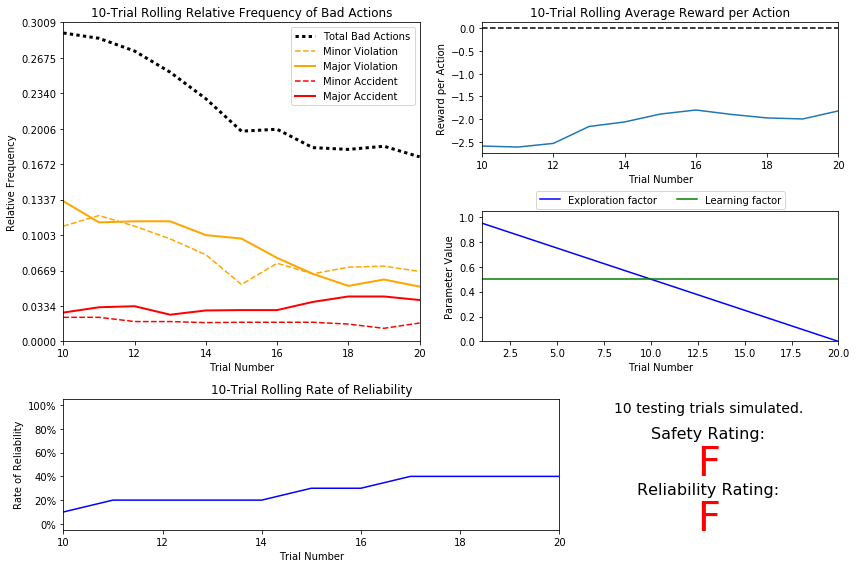

In [5]:
# Load the 'sim_default-learning' file from the default Q-Learning simulation
vs.plot_trials('sim_default-learning.csv')

### Question 6
Using the visualization above that was produced from your default Q-Learning simulation, provide an analysis and make observations about the driving agent like in **Question 3**. Note that the simulation should have also produced the Q-table in a text file which can help you make observations about the agent's learning. Some additional things you could consider:  
- *Are there any observations that are similar between the basic driving agent and the default Q-Learning agent?*
- *Approximately how many training trials did the driving agent require before testing? Does that number make sense given the epsilon-tolerance?*
- *Is the decaying function you implemented for $\epsilon$ (the exploration factor) accurately represented in the parameters panel?*
- *As the number of training trials increased, did the number of bad actions decrease? Did the average reward increase?*
- *How does the safety and reliability rating compare to the initial driving agent?*

**Answer:** We are getting better, but a _Smartcab_ is still not ready for passengers. 

It's encouraging that bad actions drop appreciably as time goes on. That is the first glimmer that the _Smartcab_ is learning from past experiences. 

In [6]:
bad_actions_percent('logs/sim_default-learning.csv')

Overall, the agent took bad actions 19.52% of the time.


We also see that the agent is taking less bad actions on average, in fact reducing them by half over the entire experiment. Interestingly major violations and accidents are still more common than minor ones, though it it looks to be closer than previously. 

Also heartening is that the "rolling average reward per action" is higher than before (about -2 vs. -6) and, more importantly, is positive in slope, which means the agent is starting to become better at its job as time goes on. 

The exploration factor decreases linearly as expected, which corresponds roughly to the decrease in bad actions and increase in average reward per action, as the agent begins to learn from past experiences. The number of training trials was 20, which makes sense as epsilon starts at 1 and decreases by 0.05 each time and begins when `epsilon < .05`. So `1 epsilon * (1 trial/.05 epsilon)  = 20 trials` makes sense. Alpha, the learning factor, was set at 0.5 and currently does not change, so all is well there. 

Finally, the rolling rate of reliability is increasing over time. We actually have a success in the first ten trials and we keep adding successes to make it to 40% reliability by the end. Not bad for the default settings and for a short learning period. 

Overall, while the safety and reliability rating is the same as the initial driving agent (still hitting people, breaking traffic laws, and failing to reach the destination more than succeeding, after all), we see that with some tweaking and maybe increased training time, _Smartcab_ has a chance at being viable. 

-----
## Improve the Q-Learning Driving Agent
The third step to creating an optimized Q-Learning agent is to perform the optimization! Now that the Q-Learning algorithm is implemented and the driving agent is successfully learning, it's necessary to tune settings and adjust learning paramaters so the driving agent learns both **safety** and **efficiency**. Typically this step will require a lot of trial and error, as some settings will invariably make the learning worse. One thing to keep in mind is the act of learning itself and the time that this takes: In theory, we could allow the agent to learn for an incredibly long amount of time; however, another goal of Q-Learning is to *transition from experimenting with unlearned behavior to acting on learned behavior*. For example, always allowing the agent to perform a random action during training (if $\epsilon = 1$ and never decays) will certainly make it *learn*, but never let it *act*. When improving on your Q-Learning implementation, consider the implications it creates and whether it is logistically sensible to make a particular adjustment.

### Improved Q-Learning Simulation Results
To obtain results from the initial Q-Learning implementation, you will need to adjust the following flags and setup:
- `'enforce_deadline'` - Set this to `True` to force the driving agent to capture whether it reaches the destination in time.
- `'update_delay'` - Set this to a small value (such as `0.01`) to reduce the time between steps in each trial.
- `'log_metrics'` - Set this to `True` to log the simluation results as a `.csv` file and the Q-table as a `.txt` file in `/logs/`.
- `'learning'` - Set this to `'True'` to tell the driving agent to use your Q-Learning implementation.
- `'optimized'` - Set this to `'True'` to tell the driving agent you are performing an optimized version of the Q-Learning implementation.

Additional flags that can be adjusted as part of optimizing the Q-Learning agent:
- `'n_test'` - Set this to some positive number (previously 10) to perform that many testing trials.
- `'alpha'` - Set this to a real number between 0 - 1 to adjust the learning rate of the Q-Learning algorithm.
- `'epsilon'` - Set this to a real number between 0 - 1 to adjust the starting exploration factor of the Q-Learning algorithm.
- `'tolerance'` - set this to some small value larger than 0 (default was 0.05) to set the epsilon threshold for testing.

Furthermore, use a decaying function of your choice for $\epsilon$ (the exploration factor). Note that whichever function you use, it **must decay to **`'tolerance'`** at a reasonable rate**. The Q-Learning agent will not begin testing until this occurs. Some example decaying functions (for $t$, the number of trials):

$$ \epsilon = a^t, \textrm{for } 0 < a < 1 \hspace{50px}\epsilon = \frac{1}{t^2}\hspace{50px}\epsilon = e^{-at}, \textrm{for } 0 < a < 1 \hspace{50px} \epsilon = \cos(at), \textrm{for } 0 < a < 1$$
You may also use a decaying function for $\alpha$ (the learning rate) if you so choose, however this is typically less common. If you do so, be sure that it adheres to the inequality $0 \leq \alpha \leq 1$.

If you have difficulty getting your implementation to work, try setting the `'verbose'` flag to `True` to help debug. Flags that have been set here should be returned to their default setting when debugging. It is important that you understand what each flag does and how it affects the simulation! 

Once you have successfully completed the improved Q-Learning simulation, run the code cell below to visualize the results. Note that log files are overwritten when identical simulations are run, so be careful with what log file is being loaded!

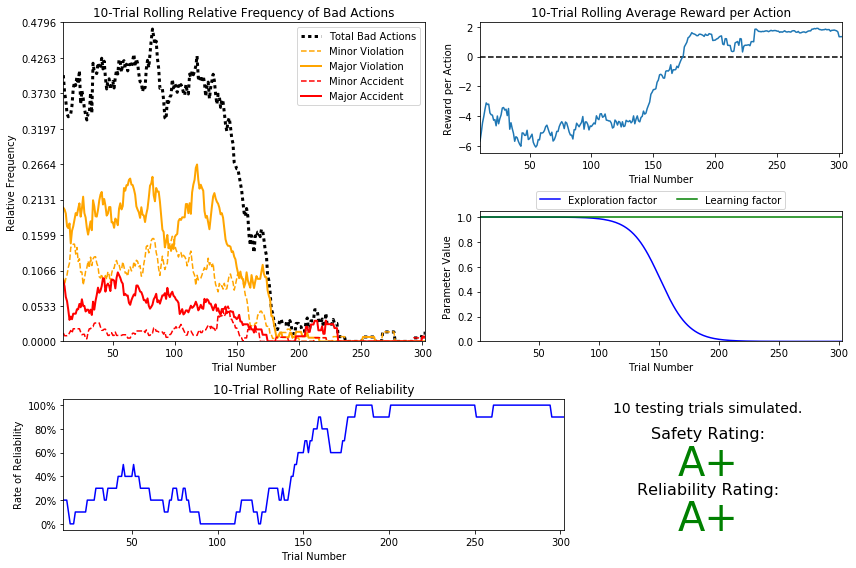

In [7]:
# Load the 'sim_improved-learning' file from the improved Q-Learning simulation
vs.plot_trials('sim_improved-learning-final.csv')

### Question 7
Using the visualization above that was produced from your improved Q-Learning simulation, provide a final analysis and make observations about the improved driving agent like in **Question 6**. Questions you should answer:  
- *What decaying function was used for epsilon (the exploration factor)?*
- *Approximately how many training trials were needed for your agent before begining testing?*
- *What epsilon-tolerance and alpha (learning rate) did you use? Why did you use them?*
- *How much improvement was made with this Q-Learner when compared to the default Q-Learner from the previous section?*
- *Would you say that the Q-Learner results show that your driving agent successfully learned an appropriate policy?*
- *Are you satisfied with the safety and reliability ratings of the *Smartcab*?*

**Answer:** Well, well. This is something. We've gotten quite reliable and safe.

In [8]:
logfile = 'logs/sim_improved-learning-final.csv'
bad_actions_percent(logfile, stop=-10)
print '\nDuring first third of training'
print '`````````````````````````````'.replace('`', '¯')
bad_actions_percent(logfile, stop=300/3+1)
print '\nDuring middle third of training'
print '````````````````````````````'.replace('`', '¯')
bad_actions_percent(logfile, start=300/3, stop=2*300/3)
print '\nDuring last third of training'
print '````````````````````````````'.replace('`', '¯')
bad_actions_percent(logfile, start=2*300/3, stop=-10)
print '\nDuring testing'
print '``````````````'.replace('`', '¯')
bad_actions_percent(logfile, start=-10)

Overall, the agent took bad actions 26.49% of the time.

During first third of training
¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯
Overall, the agent took bad actions 39.90% of the time.

During middle third of training
¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯
Overall, the agent took bad actions 25.22% of the time.

During last third of training
¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯
Overall, the agent took bad actions 1.25% of the time.

During testing
¯¯¯¯¯¯¯¯¯¯¯¯¯¯
Overall, the agent took bad actions 0.00% of the time.


I wanted my agent to act quite randomly at the start to visit as many states in the state space as possible, and then reinforce the learning behavior towards the end of training. To this end I modified a [logistic function](https://en.wikipedia.org/wiki/Logistic_function): I flipped it to start near 1 and end near zero, made the midpoint 0.5 to center the graph, then made it steep enough that f(0)≈1 and f(1)≈0. Then it was a matter of dividing `x` by the number training trials I wanted so I could step epsilon through from 1 to 0, and violá. Here's the relevant code:

    # in __init__
    self.trial = 0
    self.desired_training_trials = 300
    
    # in reset
    self.epsilon = 1/(1+math.e**(-25*(-self.trial/float(self.desired_training_trials)+.5)))
    self.trial += 1
    
My epsilon tolerance was `3.7266392841865635e-06` and was exactly the epsilon-decay function evaulated at 300, my desired number of trials. This was to ensure the training terminated when I wanted it to. The learning rate I chose was `alpha = 1`, since this is a completely determined landscape with not a lot of gray area. While there are some actions that have rewards are slightly better than others (idling at red when waypoint is right and traffic clear, as opposed to making a turn) which might have benefitted from slowly learning, I felt it was easier to immediately remember the large negative rewards from any violations. 

My choice of 300 training trials was motivated by the earlier discussion/application of the coupon collector problem. With my state space and assuming 15-20 random actions per trial, I felt 150 would be sufficient to see most states at least once. That is why you see high rate of bad actions in the first third of training. The middle third of training was the transition towards making decisions based on past experiences, and you can see the preciptious drop of bad actions and rise of reliability from trial 100 to 200. The last third of training was basically to reinforce the good behavior of the now almost completely non-random agent. I thought this would be unnecessary, but you can see that this stage of training caught some major accidents that I would have thought would've been ironed out in the first two stages of training. 

This Q-Learner has improved leaps and bounds over the unoptimized one. A+ safety and reliability ratings speak for themselves; this is largely due to increase training time. These results clearly demonstrate that the driving agent has learned an appropriate policy. 

I am definitely satisfied with the safety and reliability rating of the new and improved _Smartcab™_.

In [9]:
ninety_percent = coupon_collect(state_space, .9)
print 'Random-actor trials to see 90% of state space = {}'.format(int(math.ceil(ninety_percent/15)))

Random-actor trials to see 90% of state space = 59


One thing to keep in mind, however, is that the training time is quite long. As you can see from above, it would take many less random training trials to see 90% of the space (this is because it takes a lot longer to randomly see the last 10% of the state space than the first 10%). Following the above paradigm with around 150 training trials, I wonder if you would get the same or nearly as good results. This would be important for a company wanting to move fast. 

Further, I guarunteed my _Smartcab_ would learn the correct policy by doing enough random actions to see every state. While this is not the most optimal way (no one wants to learn by crashing into people in every possible fashion), it is effective. Forcing training trials to 200 and epsilon to 1 gives similar results: 

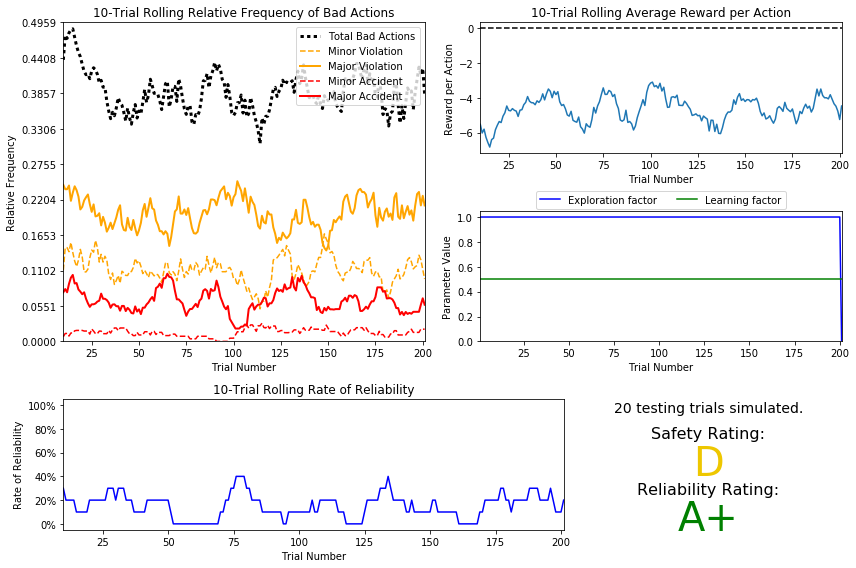

In [10]:
vs.plot_trials('sim_improved-learning.csv')

This is a completely random actor with increased testing trials. While the _Smartcab_ here got into one minor accident and got a couple of tickets, we see that it was at least as effective as a New York cab with 100 less training trials. The rationale behind is that it should explore every possible state and learn the reward for going there. I'm actually a little surprised it wasn't as effective, did I have alpha set to 1 to always listen to the reward when I thought I got the double A+'s? Can't remember. Maybe the trials were higher.  

This is, of course, against the spirit of the project, and also has the drawback of not visualizing how the _Smartcab_ would do in a testing environment before it gets there. 

### Define an Optimal Policy

Sometimes, the answer to the important question *"what am I trying to get my agent to learn?"* only has a theoretical answer and cannot be concretely described. Here, however, you can concretely define what it is the agent is trying to learn, and that is the U.S. right-of-way traffic laws. Since these laws are known information, you can further define, for each state the *Smartcab* is occupying, the optimal action for the driving agent based on these laws. In that case, we call the set of optimal state-action pairs an **optimal policy**. Hence, unlike some theoretical answers, it is clear whether the agent is acting "incorrectly" not only by the reward (penalty) it receives, but also by pure observation. If the agent drives through a red light, we both see it receive a negative reward but also know that it is not the correct behavior. This can be used to your advantage for verifying whether the **policy** your driving agent has learned is the correct one, or if it is a **suboptimal policy**.

### Question 8

1. Please summarize what the optimal policy is for the smartcab in the given environment. What would be the best set of instructions possible given what we know about the environment? 
   _You can explain with words or a table, but you should thoroughly discuss the optimal policy._

2. Next, investigate the `'sim_improved-learning.txt'` text file to see the results of your improved Q-Learning algorithm. _For each state that has been recorded from the simulation, is the **policy** (the action with the highest value) correct for the given state? Are there any states where the policy is different than what would be expected from an optimal policy?_ 

3. Provide a few examples from your recorded Q-table which demonstrate that your smartcab learned the optimal policy. Explain why these entries demonstrate the optimal policy.

4. Try to find at least one entry where the smartcab did _not_ learn the optimal policy.  Discuss why your cab may have not learned the correct policy for the given state.

Be sure to document your `state` dictionary below, it should be easy for the reader to understand what each state represents.

**Answer:**  

1.) This is the optimal policy given that dummy agents will always follow traffic signals and respect right-of-way:

| light color | desired direction of travel | situation                                          | ideal action |
| :-----------| :-------------------------- | :------------------------------------------------  | -----------: |
| red         | left                        | any                                                | **None**     |
|             | forward                     | any                                                | **None**     |
|             | right                       | `if 'left' == 'forward':`                          | **None**     |
|             |                             | `else:`                                            | **right**    |
| green       | left                        | `if 'oncoming' in ['forward', 'right']:`           | **None**     |
|             |                             | `else:`                                            | **left**     |
|             | forward                     | any                                                | **forward**  |
|             | right                       | any                                                | **right**    |

2.) The correct logfile is called `sim_improved-learning-final.txt`. Most seem to be correct upon inspection, which is evident in its high performance during testing. There are a few that have negative rewards for the bad actions, but 0's for the other two, one of which would cause a accident and one is the correct action. 

3.) My state dictionary is `('waypoint', 'light', 'left', 'right', 'oncoming')`. Here are a few examples of the cab learning optimal policy:

    ('right', 'red', 'left', 'forward', None)
     -- forward : -39.38
     -- None : -0.30
     -- right : 2.77
     -- left : -39.35
     
Right is highest, and you can go right on red if the person to your left is turning left. 

    ('right', 'green', None, 'forward', 'forward')
     -- forward : 0.87
     -- None : -4.41
     -- right : 2.53
     -- left : -0.53
     
Taking a right on green is always ok and right is highest. You go Glen Coco. 

    ('left', 'red', 'left', None, 'left')
     -- forward : -9.52
     -- None : 2.22
     -- right : 0.00
     -- left : -9.52
     
Wanting to take a left on a red through someone on our left turning left is bad. Staying put is best, which is highest. 

4.) As referenced above, this one won't do the worst thing, but won't do the best thing all the time either, a clear suboptimal policy. When wanting to go left at a red light with a car to my left crossing the intersection, the _Smartcab_ has an even chance between correctly idling at the red light and turning right into the cross traffic. See below:

    ('left', 'red', 'forward', 'left', 'left')
     -- forward : -9.93
     -- None : 0.00
     -- right : 0.00
     -- left : -9.15
     
If I had to venture as to why, perhaps during the random training it only saw this state a few times, randomly choosing only forward and left. Without seeing the reward of doing nothing or the punishment of going right and wrecking, the _Smartcab_ doesn't know which is better. **FOR REVIEWER** Does that mean we need to consider expanding our training space so that at least 3/4 possible actions should be taking at every space? Or is that needlessly inflating the training time for low performance boost?  

-----
### Optional: Future Rewards - Discount Factor, `'gamma'`
Curiously, as part of the Q-Learning algorithm, you were asked to **not** use the discount factor, `'gamma'` in the implementation. Including future rewards in the algorithm is used to aid in propagating positive rewards backwards from a future state to the current state. Essentially, if the driving agent is given the option to make several actions to arrive at different states, including future rewards will bias the agent towards states that could provide even more rewards. An example of this would be the driving agent moving towards a goal: With all actions and rewards equal, moving towards the goal would theoretically yield better rewards if there is an additional reward for reaching the goal. However, even though in this project, the driving agent is trying to reach a destination in the allotted time, including future rewards will not benefit the agent. In fact, if the agent were given many trials to learn, it could negatively affect Q-values!

### Optional Question 9
*There are two characteristics about the project that invalidate the use of future rewards in the Q-Learning algorithm. One characteristic has to do with the *Smartcab* itself, and the other has to do with the environment. Can you figure out what they are and why future rewards won't work for this project?*

**Answer:** I'll start with the environment characteristic: after the current state, the dummy agents are choosing their next action randomly if they moved at the current timepoint. The relevant code is 

    # Move to the next waypoint and choose a new one.
    action = None
    if action_okay:
        action = self.next_waypoint
        self.next_waypoint = random.choice(Environment.valid_actions[1:]) 
    reward = self.env.act(self, action)
    
Thus the state at the next timepoint is undeterminable, since we don't know where the other cars will want to go next, and we can't calculate the best action to take in the next state if we don't know what it will be when we get there. 

The _Smartcab_ characteristic is a bit murkier to me. I suppose that perhaps we don't know if we move or not, because our state may not change if we hit somebody. So then we can't take an argmax over the next state if we're not sure if the action we took changes our state. The other option is that perhaps the waypoint is recalculated at the beginning of every state, and we are asking for a future waypoint before the `RoutePlanner` can give it to us. 